QMCPy's Sobol generator is based on Magic Point Shop (MPS)'s. In this demo, we are going to illustrate the relative speed of these two generators.  We  start with importing Python libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy.testing as npt
from numpy import zeros

Next, we import QMCPy modules and also two functions gen_mps_sobol_points and gen_qmcpy_sobol_points that would return same Sobol points without scrambling from MPS and QMCPy respectively.

In [2]:
from qmcpy import * 
from workouts.wo_sequences import gen_mps_sobol_points, gen_qmcpy_sobol_points

For easy reference, we include the definitions of the generating functions here:

In [3]:
import inspect
print(inspect.getsource(gen_mps_sobol_points))
print(inspect.getsource(gen_qmcpy_sobol_points))

def gen_mps_sobol_points(n, d, Cs = "./qmcpy/third_party/magic_point_shop/sobol_Cs.col"):
    t0 = time()
    m = math.log(n, 2)
    sobol_rng = digitalseq_b2g(Cs=Cs, m=m, s=d)
    x = zeros((n, d), dtype=int64)
    for i in range(n):
        next(sobol_rng)
        x[i, :] = sobol_rng.cur
    t1 = time() - t0
    print('\nMPS Sobol Time: %.3f' % t1)
    return x, t1

def gen_qmcpy_sobol_points(n, d):
    t0 = time()
    sobol = Sobol()
    x = sobol.gen_dd_samples(replications=1, n_samples=n, dimensions=d,
                             returnDeepCopy=returnDeepCopy, scramble=False)
    t1 = time() - t0
    print('\nQMCPy Sobol Time: %.3f' % t1)
    return x, t1



Let's say we want to generate $n=2^m$ sampling points for an integration domain with dimension $d$:

In [4]:
m = 5
n = 2 ** m
d = 4

We can simply invoke the MPS and QMCPy Sobol generating functions as follows:

In [5]:
Cs = "../qmcpy/third_party/magic_point_shop/sobol_Cs.col"
mps_sobol_sample, _ = gen_mps_sobol_points(n, d, Cs)
print(mps_sobol_sample)


MPS Sobol Time: 0.824
[[         0          0          0          0]
 [2147483648 2147483648 2147483648 2147483648]
 [3221225472 1073741824 1073741824 1073741824]
 ...
 [3355443200 3355443200 2818572288 3087007744]
 [2281701376  134217728 1744830464 2013265920]
 [ 134217728 2281701376 3892314112 4160749568]]


In [6]:
qmcpy_sobol_sample, _ = gen_qmcpy_sobol_points(n, d)
print(qmcpy_sobol_sample)


QMCPy Sobol Time: 0.008
[[         0          0          0          0]
 [2147483648 2147483648 2147483648 2147483648]
 [3221225472 1073741824 1073741824 1073741824]
 ...
 [3355443200 3355443200 2818572288 3087007744]
 [2281701376  134217728 1744830464 2013265920]
 [ 134217728 2281701376 3892314112 4160749568]]


To ensure the two arrays of sampling points are the same, we could use the following testing utility. If it does not throw an eerror, it means they are equal.

In [7]:
npt.assert_array_equal(mps_sobol_sample, qmcpy_sobol_sample) 

To see the relative speed of the two libraries for generating Sobol points as we increase number of sampling points, we could use the following code to collect the time statistics:

In [8]:
from IPython.utils import io
with io.capture_output() as captured: # to suppress output of this notebook cell
    d = 4
    m_values = list(range(1,22,2))
    sampling_points = [2**m for m in m_values]
    mps_time = [0 for m in m_values]
    qmcpy_time = [0 for m in m_values]
    for i in range(len(m_values)):
        m = m_values[i]
        n = sampling_points[i]
        mps_sobol_sample, mps_time[i] = gen_mps_sobol_points(n, d, Cs)
        qmcpy_sobol_sample, qmcpy_time[i] = gen_qmcpy_sobol_points(n, d)
        npt.assert_array_equal(mps_sobol_sample, qmcpy_sobol_sample) 

Lastly, we compute the speedup factors and plot a log-log graph below.

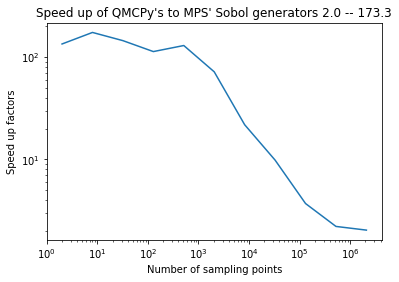

In [9]:
speedup = [t1 / t2 for t1, t2 in zip(mps_time, qmcpy_time)]
plt.loglog(sampling_points, speedup)
plt.title("Speed up of QMCPy's to MPS' Sobol generators %.1f -- %.1f" % (min(speedup), max(speedup)))
plt.xlabel("Number of sampling points")
plt.ylabel("Speed up factors")
plt.savefig('../outputs/comparison_tests/mps_vs_qmcpy_sobol.png', dpi=200)